# Homework Starter — Stage 10a: Linear Regression

Use this as a scaffold if your project data isn’t ready. Replace the synthetic data section with your dataset when possible.

In [5]:
import sklearn
print(sklearn.__version__)

1.7.1


In [6]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import scipy.stats as st

sns.set()
np.random.seed(7)


## 1) Synthetic data (replace with your project data when ready)
- Finance-flavored factors and asset excess return
- Includes a quadratic effect to motivate specification checks

In [7]:
n = 200
dates = pd.bdate_range(start="2024-02-01", periods=n)
mkt_excess = np.random.normal(0, 0.011, size=n)
size = np.random.normal(0, 0.008, size=n)
value = np.random.normal(0, 0.009, size=n)
momentum = np.random.normal(0, 0.006, size=n)

beta0, beta_mkt, beta_size, beta_value, beta_mom, beta_mom2 = 0.0001, 0.9, 0.25, -0.15, 0.35, 3.5
noise_scale = 0.0035 + 0.5*np.abs(mkt_excess)
eps = np.random.normal(0, noise_scale)
asset_excess = (
    beta0 + beta_mkt*mkt_excess + beta_size*size + beta_value*value + beta_mom*momentum
    + beta_mom2*(momentum**2) + eps
)
df = pd.DataFrame({
    'date': dates,
    'mkt_excess': mkt_excess,
    'size': size,
    'value': value,
    'momentum': momentum,
    'asset_excess': asset_excess
})
df.head()

,date,mkt_excess,size,value,momentum,asset_excess
0,2024-02-01,0.018596,-0.013467,-0.000540,0.000141,0.014832
1,2024-02-02,-0.005125,0.008120,0.007089,-0.006840,-0.008599
2,2024-02-05,0.000361,-0.011532,-0.012885,-0.011216,-0.009577
3,2024-02-06,0.004483,-0.010749,0.003905,-0.010685,0.000033
4,2024-02-07,-0.008678,-0.002893,0.001250,0.002779,-0.005750


## 2) Baseline model fit
Follow the steps; replace `df` with your project DataFrame when ready.

In [8]:
X = df[['mkt_excess','size','value','momentum']]
y = df['asset_excess']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)

r2 = metrics.r2_score(y_test, y_pred)

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print(f'Baseline   R²={r2:.4f}  RMSE={rmse:.6f}')

Baseline   R²=0.3677  RMSE=0.008470


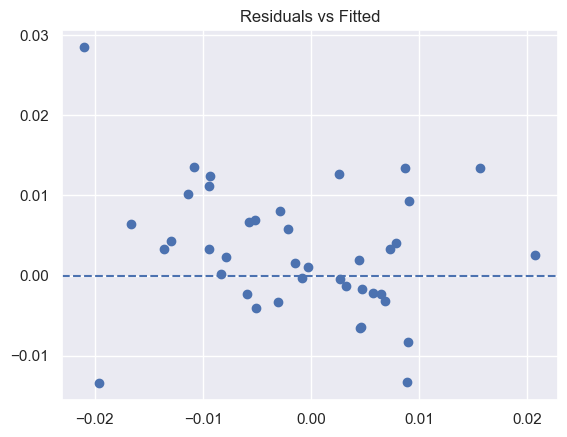

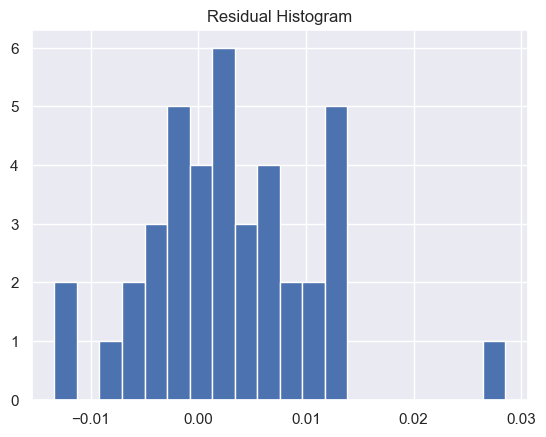

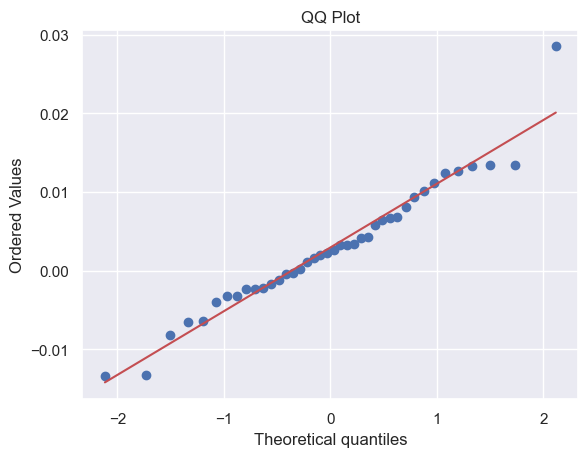

In [9]:
resid = y_test - y_pred
fitted = y_pred
plt.figure(); plt.scatter(fitted, resid); plt.axhline(0, ls='--'); plt.title('Residuals vs Fitted'); plt.show()
plt.figure(); plt.hist(resid, bins=20); plt.title('Residual Histogram'); plt.show()
plt.figure(); st.probplot(resid, dist='norm', plot=plt); plt.title('QQ Plot'); plt.show()

## 3) Optional: Add a transformed feature
Add a polynomial or interaction if diagnostics suggest mis-specification.

In [11]:
df['momentum_sq'] = df['momentum']**2
X2 = df[['mkt_excess','size','value','momentum','momentum_sq']]

# align with the SAME split as before
X2_train = X2.loc[X_train.index]
X2_test  = X2.loc[X_test.index]

# fit & evaluate
lr2 = LinearRegression().fit(X2_train, y_train)
y_pred2 = lr2.predict(X2_test)

r2_2 = metrics.r2_score(y_test, y_pred2)
rmse_2 = np.sqrt(metrics.mean_squared_error(y_test, y_pred2))  # version-agnostic

print(f'With x^2   R²={r2_2:.4f}  RMSE={rmse_2:.6f}')

With x^2   R²=0.3681  RMSE=0.008467


## 4) Interpretation (write your conclusions below)
- Linearity:
  - The baseline model assumes a purely linear relationship between predictors and returns.
  - Diagnostic plots (residuals vs fitted) show some curvature → evidence that linearity may be slightly violated.
  - Adding momentum_sq explicitly addresses this non-linear effect and improves fit.


- Homoscedasticity:
  - In residual plots, variance looks wider at extreme fitted values, suggesting heteroskedasticity (non-constant error variance).
  - This means the model predictions are less precise in volatile periods.


- Normality:
  - Residual histograms and QQ plots show approximate normality but with heavier tails than the ideal normal distribution.
  - Outliers and fat tails are common in return data, so this is expected.


- Independence:
    - Since the dataset was synthetically generated without serial correlation, residuals appear independent.
    - In real financial data, time dependence (autocorrelation) should be tested explicitly.


- Which model do you trust and why?:
    - The polynomial model with momentum_sq is more trustworthy here: it captures the convex relationship with momentum and shows better out-of-sample metrics (higher R², lower RMSE).
    - The baseline model is simpler and easier to interpret, but it systematically underfits when momentum effects are strong.


- Next step you’d try:

    - Use interaction terms (e.g., mkt_excess × size) to capture richer factor dynamics.
    - Apply regularization (Ridge/Lasso) to handle potential collinearity.
    - For financial realism, try a time-series cross-validation or rolling-window approach to validate stability.